# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.1+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32

In [4]:
resources_folder = 'resources/classification'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

print(len(data))
print(data[0].shape)
print(data[0][0].shape)

loaded numpy bitmaps, 8 classes
8
(144722, 784)
(784,)


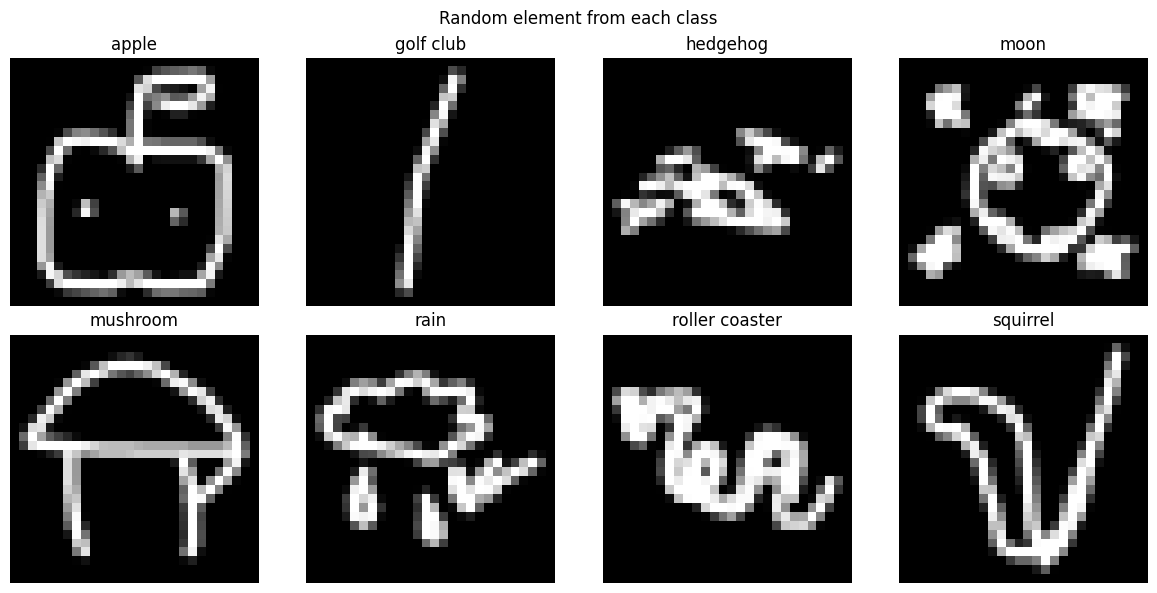

In [5]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManager import DataManager

split = 0.8
data_manager = DataManager()

training_data, training_labels, validation_data, validation_labels = data_manager.split_data(split, data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

In [8]:
from dataset_creation.GraysacleDataset import GrayscaleDataset

len_subset = 2000

training_set = GrayscaleDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)
validation_set = GrayscaleDataset(data=shuffled_validation_data[:len_subset], labels=shuffled_validation_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

## Autoencoder class

In [9]:
from src.autoencoder import Autoencoder

## Try with simple model

In [33]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 4 * 3, WIDTH * HEIGHT // 2]
autoencoder_model = Autoencoder(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [34]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=588, bias=True)
  (encoder_relu_0): ReLU()
  (encoder_dropout_0): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_0): BatchNorm1d(588, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Linear(in_features=588, out_features=392, bias=True)
)
Sequential(
  (decoder_2): Linear(in_features=392, out_features=588, bias=True)
  (decoder_relu_2): ReLU()
  (encoder_dropout_2): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_2): BatchNorm1d(588, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_1): Linear(in_features=588, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 2.0


In [12]:
num_epochs = 40
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.0960	Test Loss 0.0880	Train PSNR: 10.3674	Train SSIM: 0.0610	Validation PSNR: 10.3486	Validation SSIM: 0.0607
Epoch [2/40]	Loss: 0.0861	Test Loss 0.0843	Train PSNR: 10.9159	Train SSIM: 0.1120	Validation PSNR: 10.8761	Validation SSIM: 0.1087
Epoch [3/40]	Loss: 0.0784	Test Loss 0.0814	Train PSNR: 11.1668	Train SSIM: 0.1417	Validation PSNR: 11.1034	Validation SSIM: 0.1377
Epoch [4/40]	Loss: 0.0755	Test Loss 0.0690	Train PSNR: 11.5162	Train SSIM: 0.1661	Validation PSNR: 11.4387	Validation SSIM: 0.1602
Epoch [5/40]	Loss: 0.0734	Test Loss 0.0701	Train PSNR: 11.8310	Train SSIM: 0.2257	Validation PSNR: 11.7321	Validation SSIM: 0.2174
Epoch [6/40]	Loss: 0.0601	Test Loss 0.0686	Train PSNR: 12.0184	Train SSIM: 0.2499	Validation PSNR: 11.8972	Validation SSIM: 0.2399
Epoch [7/40]	Loss: 0.0700	Test Loss 0.0548	Train PSNR: 12.2190	Train SSIM: 0.2697	Validation PSNR: 12.0903	Validation SSIM: 0.2580
Epoch [8/40]	Loss: 0.0543	Test Loss 0.0612	Train PSNR: 12.4160	Train SSIM: 0.2985	V

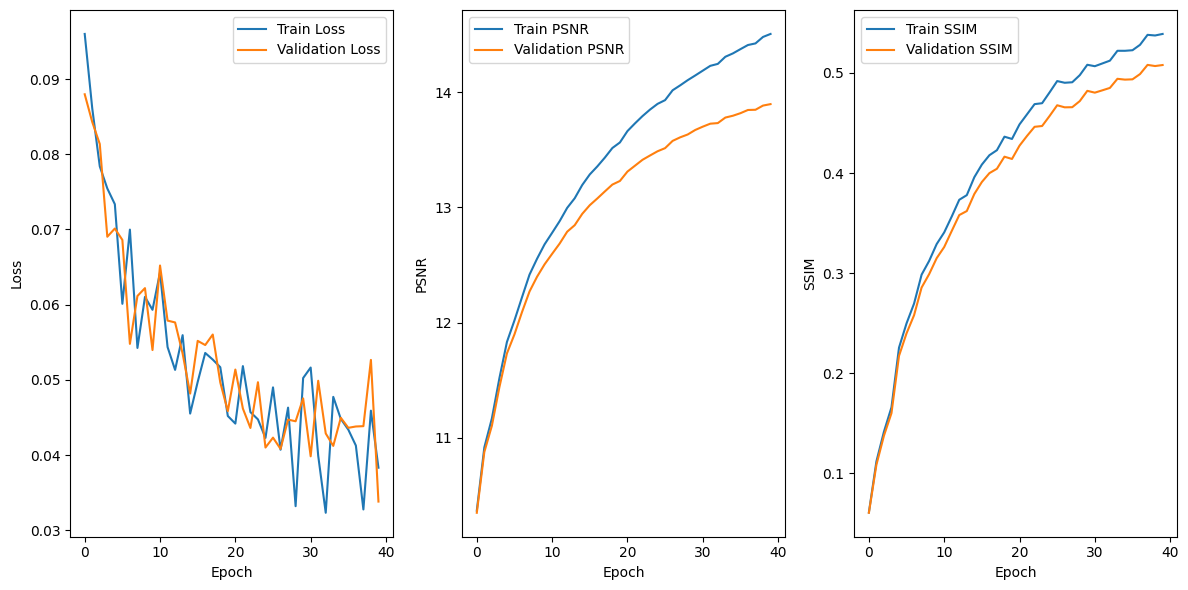

In [13]:
# plot Train and Test Loss, PSNR and SSIM values
autoencoder_model.plot_psnr_ssim()

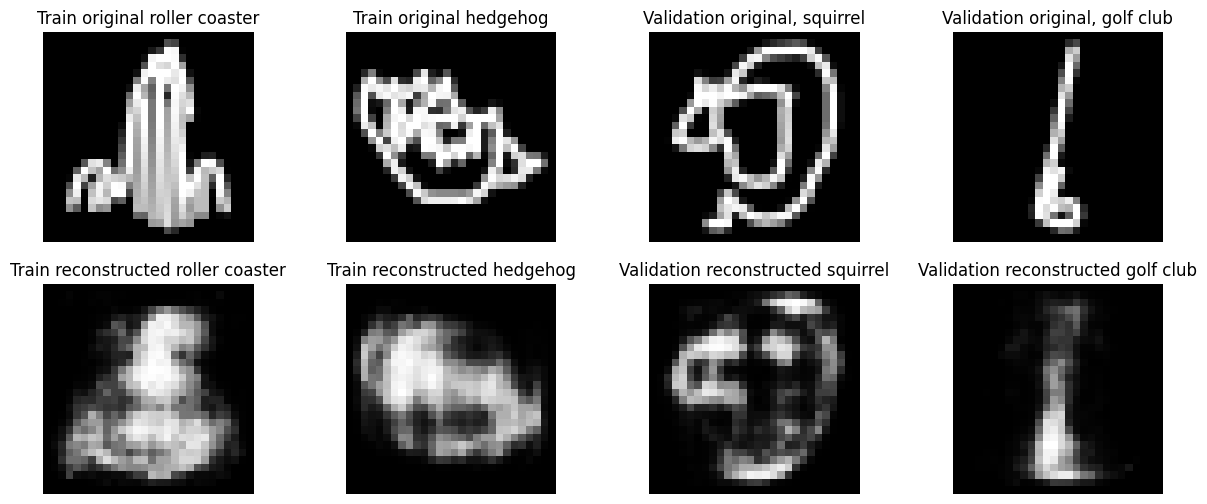

In [14]:
# plot some original and reconstructed images
autoencoder_model.show_images(training_set, validation_set)

In [15]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [16]:
# Show the lowest psnr then ssim in the test set
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]} | {lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]} | {lowest_ssim[1]}')

Lowest PSNR index: 1974 | 9.088497534049074, Lowest SSIM index: 431 | 0.10338603483440385


[1974, 9.088497534049074]
[431, 0.10338603483440385]


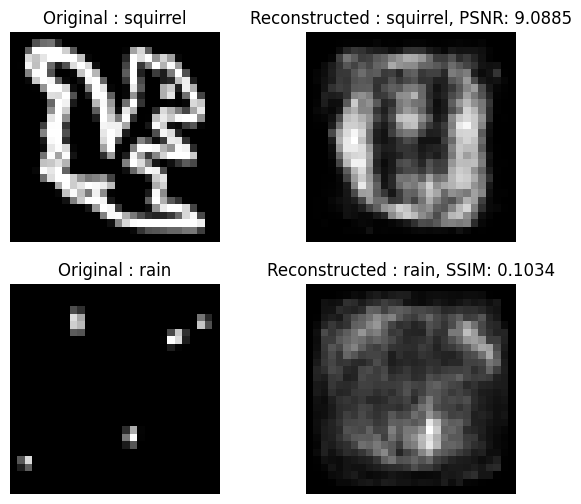

In [17]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
print(lowest_psnr)
print(lowest_ssim)
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Try with a different model architecture

In [18]:
layers = [WIDTH * HEIGHT, WIDTH * HEIGHT // 2]
autocoder_2 = Autoencoder(layers, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True)
autocoder_2.to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / autocoder_2.architecture[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=784, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=784, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 1.0


In [19]:
# Call the function
num_epochs = 40

autocoder_2.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.0599	Test Loss 0.0670	Train PSNR: 11.9813	Train SSIM: 0.2591	Validation PSNR: 11.8480	Validation SSIM: 0.2500
Epoch [2/40]	Loss: 0.0423	Test Loss 0.0543	Train PSNR: 13.7400	Train SSIM: 0.3333	Validation PSNR: 13.3801	Validation SSIM: 0.3141
Epoch [3/40]	Loss: 0.0291	Test Loss 0.0441	Train PSNR: 15.2135	Train SSIM: 0.4074	Validation PSNR: 14.5893	Validation SSIM: 0.3809
Epoch [4/40]	Loss: 0.0269	Test Loss 0.0305	Train PSNR: 16.4120	Train SSIM: 0.4689	Validation PSNR: 15.5455	Validation SSIM: 0.4348
Epoch [5/40]	Loss: 0.0188	Test Loss 0.0321	Train PSNR: 17.5265	Train SSIM: 0.5065	Validation PSNR: 16.4552	Validation SSIM: 0.4686
Epoch [6/40]	Loss: 0.0177	Test Loss 0.0205	Train PSNR: 18.6281	Train SSIM: 0.5165	Validation PSNR: 17.3676	Validation SSIM: 0.4827
Epoch [7/40]	Loss: 0.0122	Test Loss 0.0171	Train PSNR: 19.6216	Train SSIM: 0.5419	Validation PSNR: 18.1606	Validation SSIM: 0.5076
Epoch [8/40]	Loss: 0.0111	Test Loss 0.0127	Train PSNR: 20.3665	Train SSIM: 0.5532	V

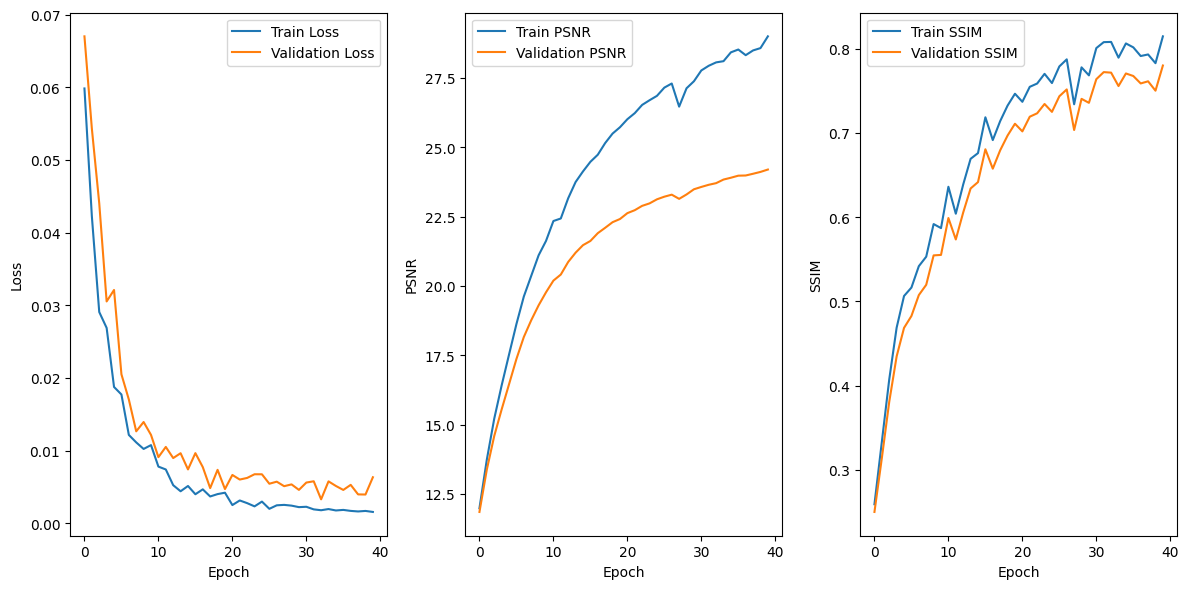

In [20]:
autocoder_2.plot_psnr_ssim()

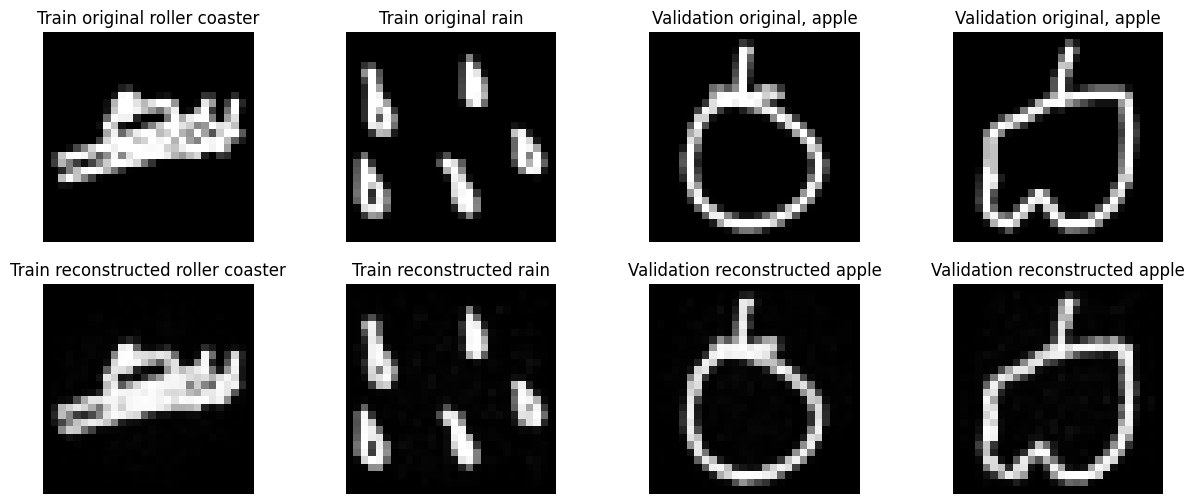

In [21]:
autocoder_2.show_images(training_set, validation_set)

Lowest PSNR index: 1974|16.3615585299651, Lowest SSIM index: 431|0.3478752574919314


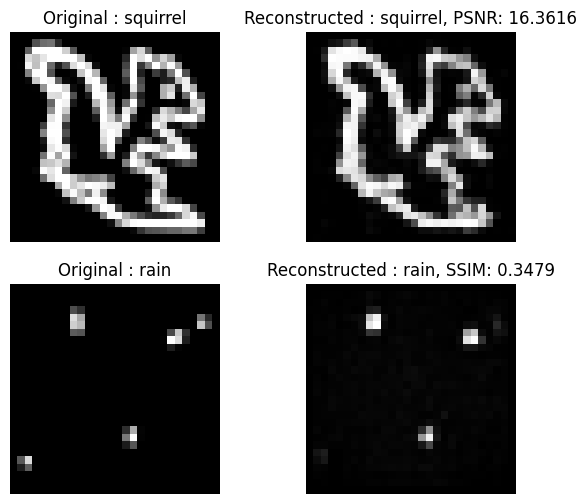

In [22]:
lowest_psnr, lowest_ssim = autocoder_2.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

autocoder_2.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Try with resnet18 architecture

In [23]:
# Use pretrained model

# Load pretrained model

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

# Print pretrained model architecture
print(pretrained_model)

# Freeze all layers

for param in pretrained_model.parameters():
    param.requires_grad = False

# Add custom layers

pretrained_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, nb_classes)
)

# Print new model architecture
print(pretrained_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/nprzybylski/Cours/project/env_doodle/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nprzybylski/Cours/project/env_doodle/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Define a function to train the model
def train_pretained_model():
    pass

## Generating images

In [25]:
def return_classes_mean_encoded_vector(model, images_set):
    mean_encoded_vectors = []
    mean_vectors_size = model.architecture[-1]
    count_classes_number = [0] * nb_classes

    for i in range(nb_classes):
        mean_encoded_vectors.append(np.zeros(mean_vectors_size))

    for batch in images_set:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        encoded, decoded = model(images)
        encoded_np = encoded.cpu().detach().numpy()

        for i in range(len(images)):
            mean_encoded_vectors[labels[i]] += encoded_np[i]

        count_classes_number[labels[i]] += 1
            
    for i in range(nb_classes):
        mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0

        print(f'Class {classes[i]} range of mean encoded vector: [{mean_encoded_vectors[i].min()}, {mean_encoded_vectors[i].max()}]')

    return mean_encoded_vectors

def generated_images_for_mean_vector(mean_encoded_vectors, model):
    generated_images = []

    decoder = model.decoder
    for i in range(nb_classes):
        mean_vector = mean_encoded_vectors[i]
        double_mean_vector = np.array([mean_vector]).astype(np.float32)
        mean_vector_torch = torch.from_numpy(double_mean_vector).to(device)

        decoded = decoder(mean_vector_torch)

        generated_images.append(decoded.cpu().detach().numpy()[0].reshape(HEIGHT, WIDTH))

    return generated_images

def show_generated_images(generated_images):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(nb_classes):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(generated_images[i], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(classes[i])

    plt.tight_layout()
    plt.suptitle('Generated images')

    plt.subplots_adjust(top=0.9)

    plt.show()

In [26]:
def create_alternative_version(mean_vector, weight=0.1):
    alternative_mean_vector = mean_vector.copy()
    # Vector is composed of float values 
    # use gaussian distribution to generate altertivate vector based on mean one

    for i in range(len(mean_vector)):
        alternative_mean_vector[i] = np.random.normal(mean_vector[i], weight)
    
    return alternative_mean_vector

Class apple range of mean encoded vector: [-1.4462995624542236, 0.8466180868943533]
Class golf club range of mean encoded vector: [-0.7020424403396307, 0.5539776515902257]
Class hedgehog range of mean encoded vector: [-0.8717046090668322, 0.9273990163616106]
Class moon range of mean encoded vector: [-2.1380219725417158, 1.7954560171739729]
Class mushroom range of mean encoded vector: [-0.32427895842499327, 0.2873623595964922]
Class rain range of mean encoded vector: [-0.2753870807344617, 0.23167473777057299]
Class roller coaster range of mean encoded vector: [-0.5334022333078524, 0.5894177291907516]
Class squirrel range of mean encoded vector: [-0.5760694723722397, 0.5047129475602916]


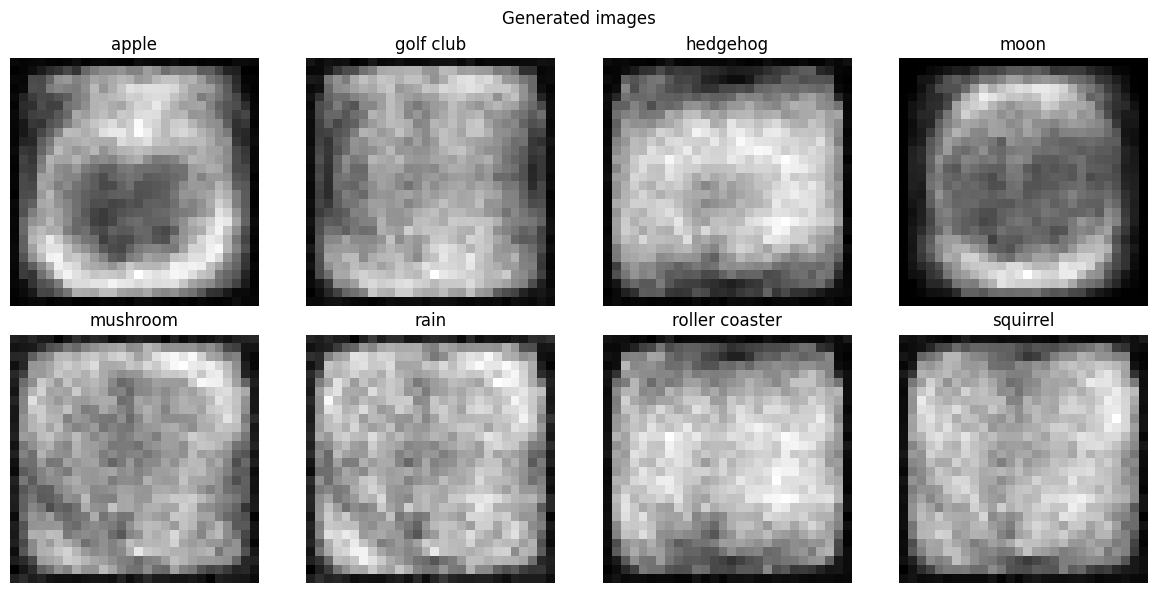

In [27]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

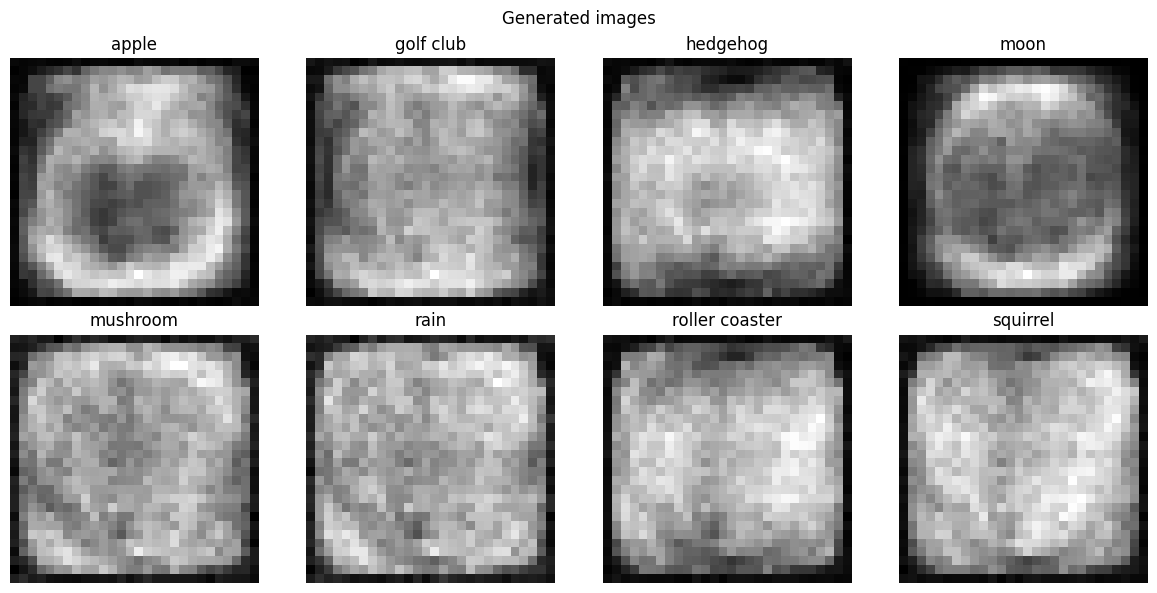

In [28]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)

Class apple range of mean encoded vector: [-1.0330711164394346, 0.6047272046574024]
Class golf club range of mean encoded vector: [-0.7020424398721433, 0.5539776516369745]
Class hedgehog range of mean encoded vector: [-1.0896307618010277, 1.1592487704520131]
Class moon range of mean encoded vector: [-0.3887312684998368, 0.3264465490870722]
Class mushroom range of mean encoded vector: [-0.6022323500250234, 0.5336729530020714]
Class rain range of mean encoded vector: [-0.27538708120194916, 0.23167473788744483]
Class roller coaster range of mean encoded vector: [-0.6096025527525348, 0.6736202613980162]
Class squirrel range of mean encoded vector: [-0.9217111542996238, 0.8075407160964667]


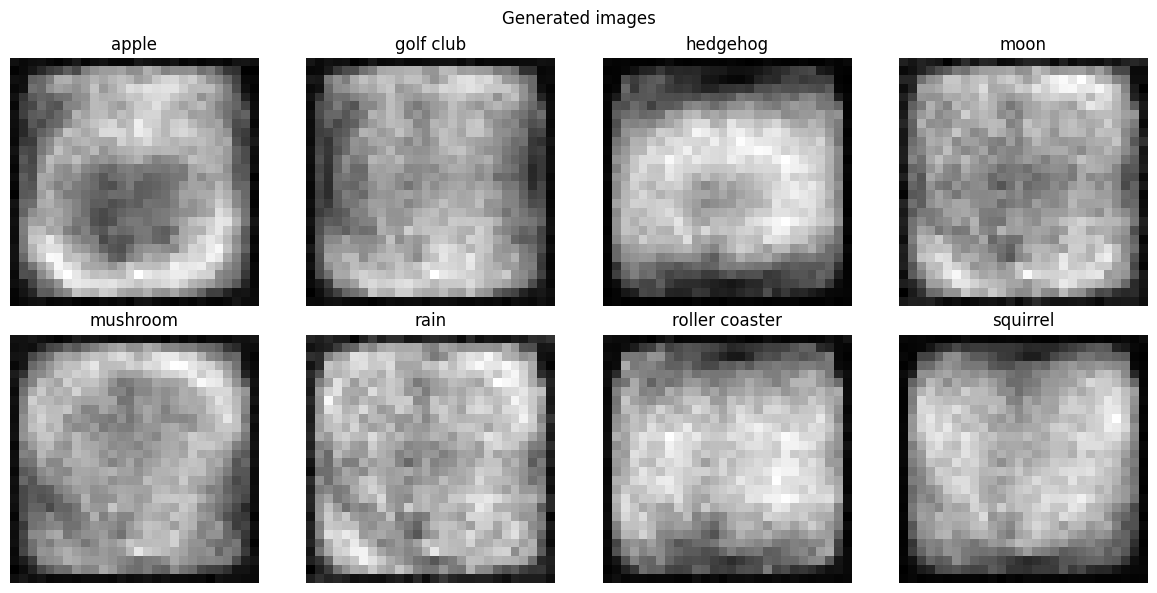

In [29]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

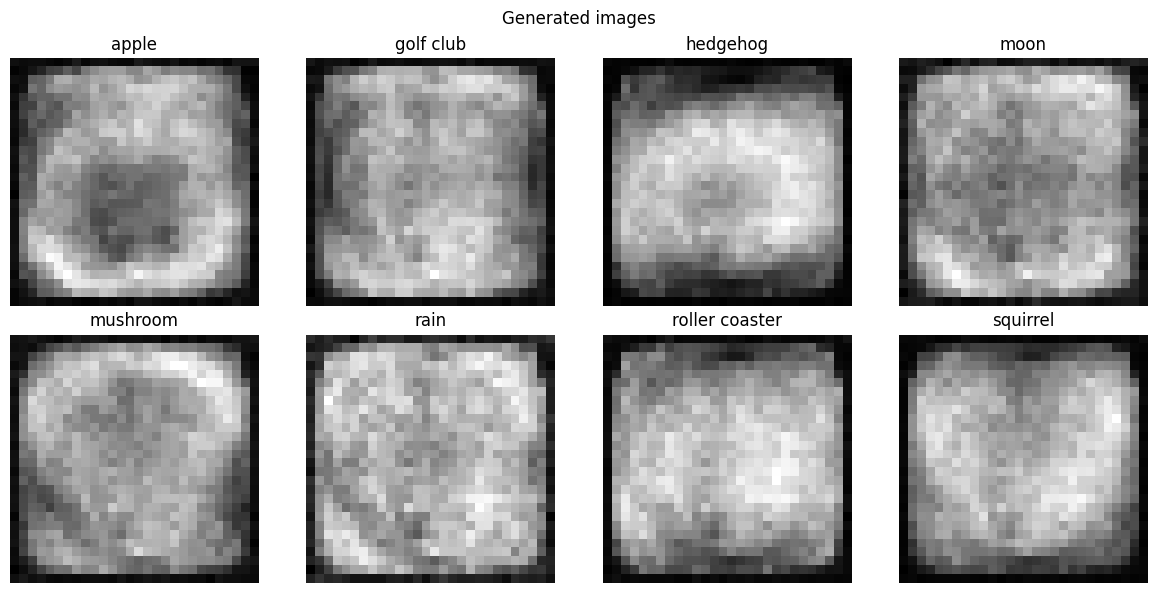

In [30]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)